In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, MeanShift, AffinityPropagation, SpectralClustering
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import umap
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split


#reading the dataset from drive
data=pd.read_csv('Cost_of_Living_Index_by_Country_2024.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rank                            121 non-null    int64  
 1   Country                         121 non-null    object 
 2   Cost of Living Index            121 non-null    float64
 3   Rent Index                      121 non-null    float64
 4   Cost of Living Plus Rent Index  121 non-null    float64
 5   Groceries Index                 121 non-null    float64
 6   Restaurant Price Index          121 non-null    float64
 7   Local Purchasing Power Index    121 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 7.7+ KB


# Data Cleaning

In [11]:
# Handling missing values, encoding categorical variables, scaling numerical variables

# Identify columns with missing values
missing_values = data.isnull().sum()
missing_values.info()
# Impute missing values for numerical columns with median
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# Impute missing values for categorical columns with mode
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()
        if not mode_value.empty:
            data[col].fillna(mode_value[0], inplace=True)

# Encode the categorical 'Country' column
le = LabelEncoder()
data['Country'] = le.fit_transform(data['Country'])

# Select the features for clustering
features = data.drop(columns=['Rank'])  # Dropping 'Rank' as it's not a feature for clustering

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

features.head()

<class 'pandas.core.series.Series'>
Index: 8 entries, Rank to Local Purchasing Power Index
Series name: None
Non-Null Count  Dtype
--------------  -----
8 non-null      int64
dtypes: int64(1)
memory usage: 428.0+ bytes


,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,103,101.1,46.5,74.9,109.1,97.0,158.7
1,7,85.0,36.7,61.8,81.6,83.3,54.6
2,45,83.0,39.2,62.0,88.4,86.8,120.3
3,95,76.7,67.2,72.1,74.6,50.4,111.1
4,10,76.6,19.0,48.9,80.8,69.4,43.5


# Exploratory Data Analysis

In [12]:
#To find missing values
data.count()

Rank                              121
Country                           121
Cost of Living Index              121
Rent Index                        121
Cost of Living Plus Rent Index    121
Groceries Index                   121
Restaurant Price Index            121
Local Purchasing Power Index      121
dtype: int64

In [13]:
#To find missing values
data.isnull().sum()

Rank                              0
Country                           0
Cost of Living Index              0
Rent Index                        0
Cost of Living Plus Rent Index    0
Groceries Index                   0
Restaurant Price Index            0
Local Purchasing Power Index      0
dtype: int64

In [14]:
#identify datatypes
data.dtypes

Rank                                int64
Country                             int32
Cost of Living Index              float64
Rent Index                        float64
Cost of Living Plus Rent Index    float64
Groceries Index                   float64
Restaurant Price Index            float64
Local Purchasing Power Index      float64
dtype: object

In [15]:
#describe features
data.describe()

,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,61.000000,60.000000,43.555372,16.052893,30.357851,44.228926,36.471074,65.094215
std,35.073732,35.073732,16.147574,11.412267,13.263721,17.055109,18.258110,39.569094
min,1.000000,0.000000,18.800000,2.400000,11.100000,17.500000,12.800000,2.300000
25%,31.000000,30.000000,30.200000,8.500000,19.800000,31.600000,21.600000,34.800000
50%,61.000000,60.000000,39.500000,12.400000,27.000000,40.500000,33.100000,50.600000
75%,91.000000,90.000000,52.800000,20.100000,37.000000,53.700000,47.200000,99.400000
max,121.000000,120.000000,101.100000,67.200000,74.900000,109.100000,97.000000,182.500000


In [7]:

#Identifying duplicate records
print(data.duplicated().sum())

0


In [16]:
data.head()

,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,1,103,101.1,46.5,74.9,109.1,97.0,158.7
1,2,7,85.0,36.7,61.8,81.6,83.3,54.6
2,3,45,83.0,39.2,62.0,88.4,86.8,120.3
3,4,95,76.7,67.2,72.1,74.6,50.4,111.1
4,5,10,76.6,19.0,48.9,80.8,69.4,43.5


## Determine optimal value of K number of cluster


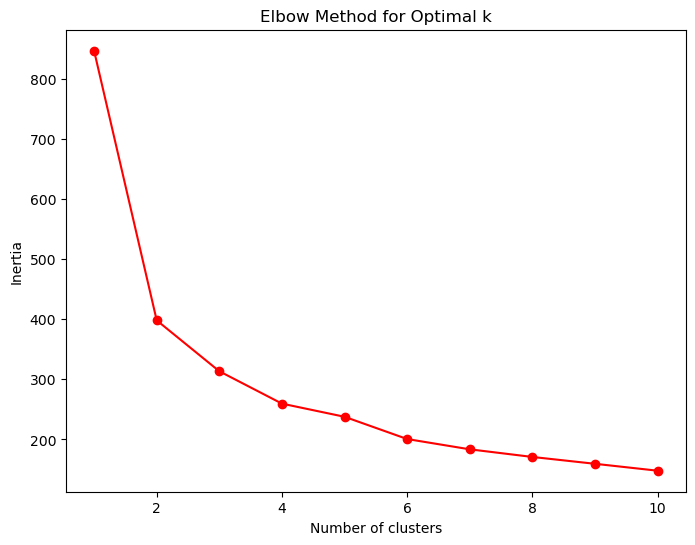

In [17]:
# Use the Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 11)  # Testing k values from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-', color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

     Country  Cost of Living Index  Rent Index  \
0        103                 101.1        46.5   
1          7                  85.0        36.7   
2         45                  83.0        39.2   
3         95                  76.7        67.2   
4         10                  76.6        19.0   
..       ...                   ...         ...   
116        9                  22.5         2.4   
117       46                  21.2         5.6   
118       32                  21.0         3.7   
119       63                  20.4         4.3   
120       81                  18.8         2.8   

     Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  \
0                              74.9            109.1                    97.0   
1                              61.8             81.6                    83.3   
2                              62.0             88.4                    86.8   
3                              72.1             74.6                    50.4   

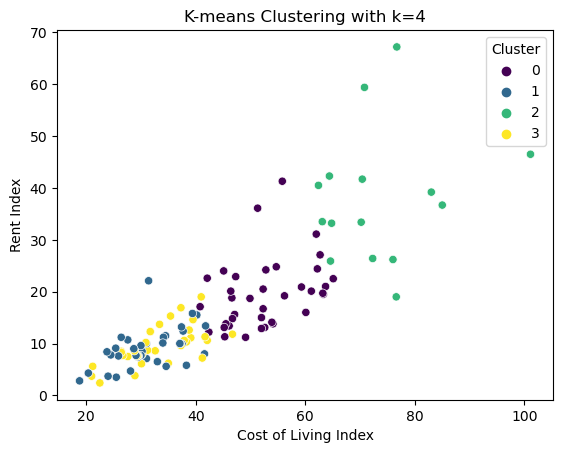

In [20]:
# Run K-means clustering with k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

# Assign cluster labels to the original data
features['Cluster'] = kmeans.labels_

# Print the DataFrame with clusters
print(features)

# Visualizing the clusters (using the first two features for simplicity)
sns.scatterplot(x=features['Cost of Living Index'], y=features['Rent Index'], hue=features['Cluster'], palette='viridis')
plt.title('K-means Clustering with k=4')
plt.xlabel('Cost of Living Index')
plt.ylabel('Rent Index')
plt.show()

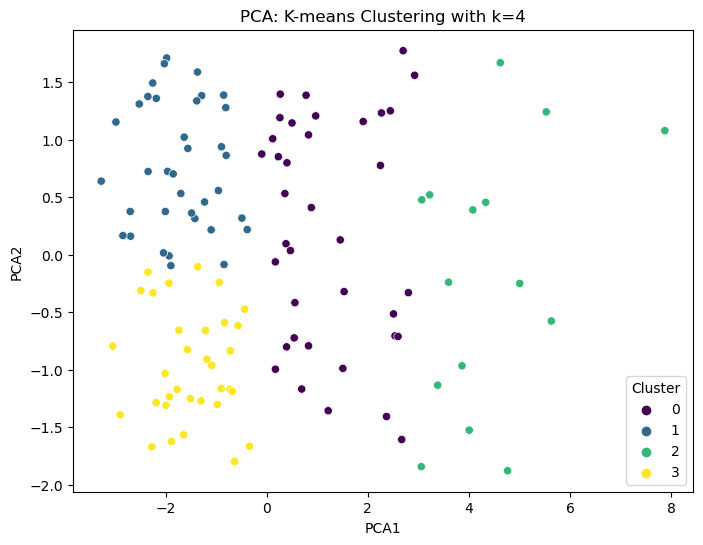

In [22]:

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create a DataFrame for the PCA result
features_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
features_pca['Cluster'] = features['Cluster']

# Plotting the PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=features_pca)
plt.title('PCA: K-means Clustering with k=4')
plt.show()

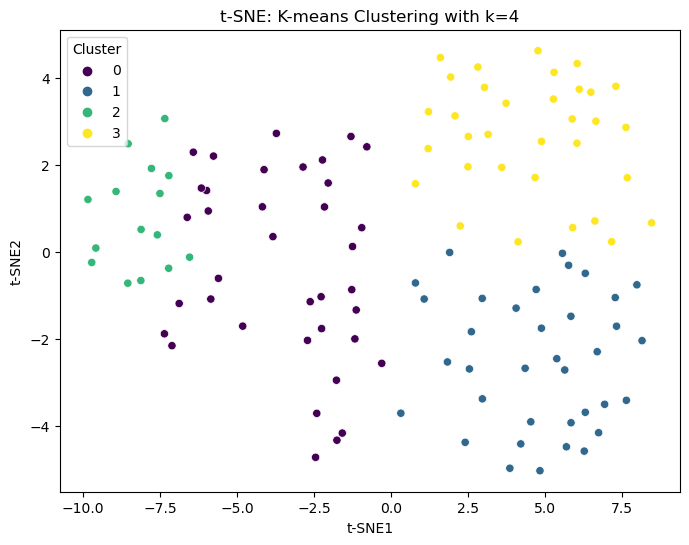

In [23]:
# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_features)

# Create a DataFrame for the t-SNE result
features_tsne = pd.DataFrame(tsne_result, columns=['t-SNE1', 't-SNE2'])
features_tsne['Cluster'] = features['Cluster']

# Plotting the t-SNE result
plt.figure(figsize=(8, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', palette='viridis', data=features_tsne)
plt.title('t-SNE: K-means Clustering with k=4')
plt.show()

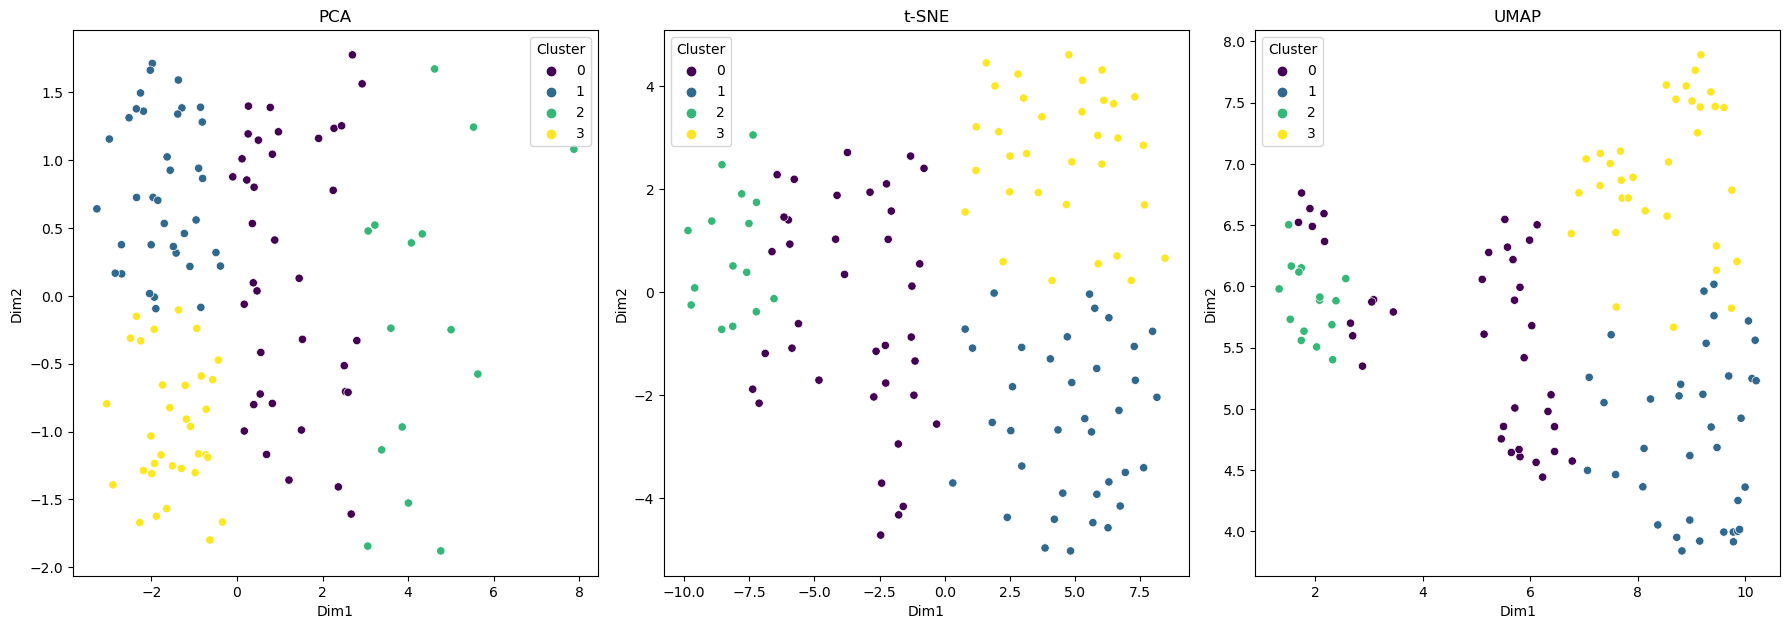

In [28]:

# Initialize different dimensionality reduction methods
methods = {
    'PCA': PCA(n_components=2),
    't-SNE': TSNE(n_components=2, random_state=42),
    'UMAP': umap.UMAP(n_components=2, random_state=42),
}

# Apply K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)
features['Cluster'] = kmeans.labels_

# Plot the results of each dimensionality reduction method
plt.figure(figsize=(18, 12))

for i, (name, method) in enumerate(methods.items()):
    reduced_data = method.fit_transform(scaled_features)
    df_reduced = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])
    df_reduced['Cluster'] = features['Cluster']
    
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x='Dim1', y='Dim2', hue='Cluster', palette='viridis', data=df_reduced)
    plt.title(name)

plt.tight_layout()
plt.show()

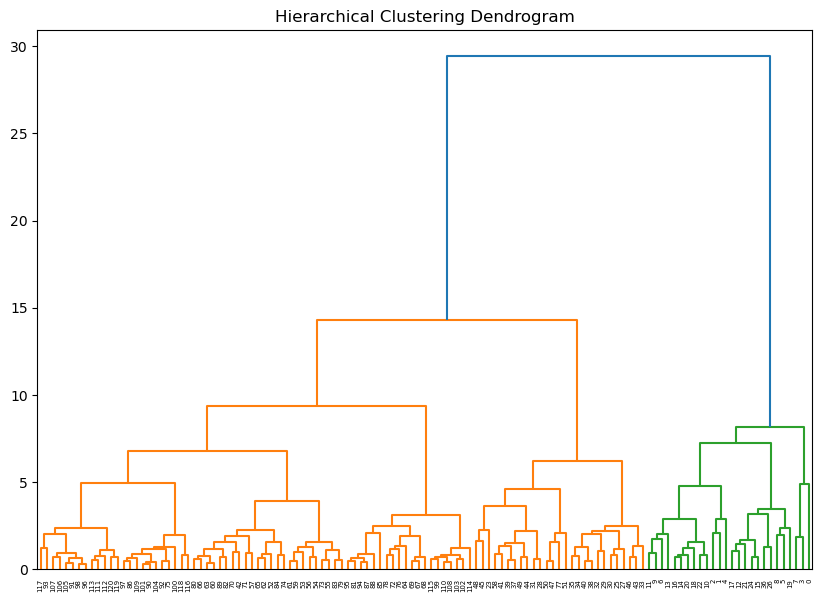

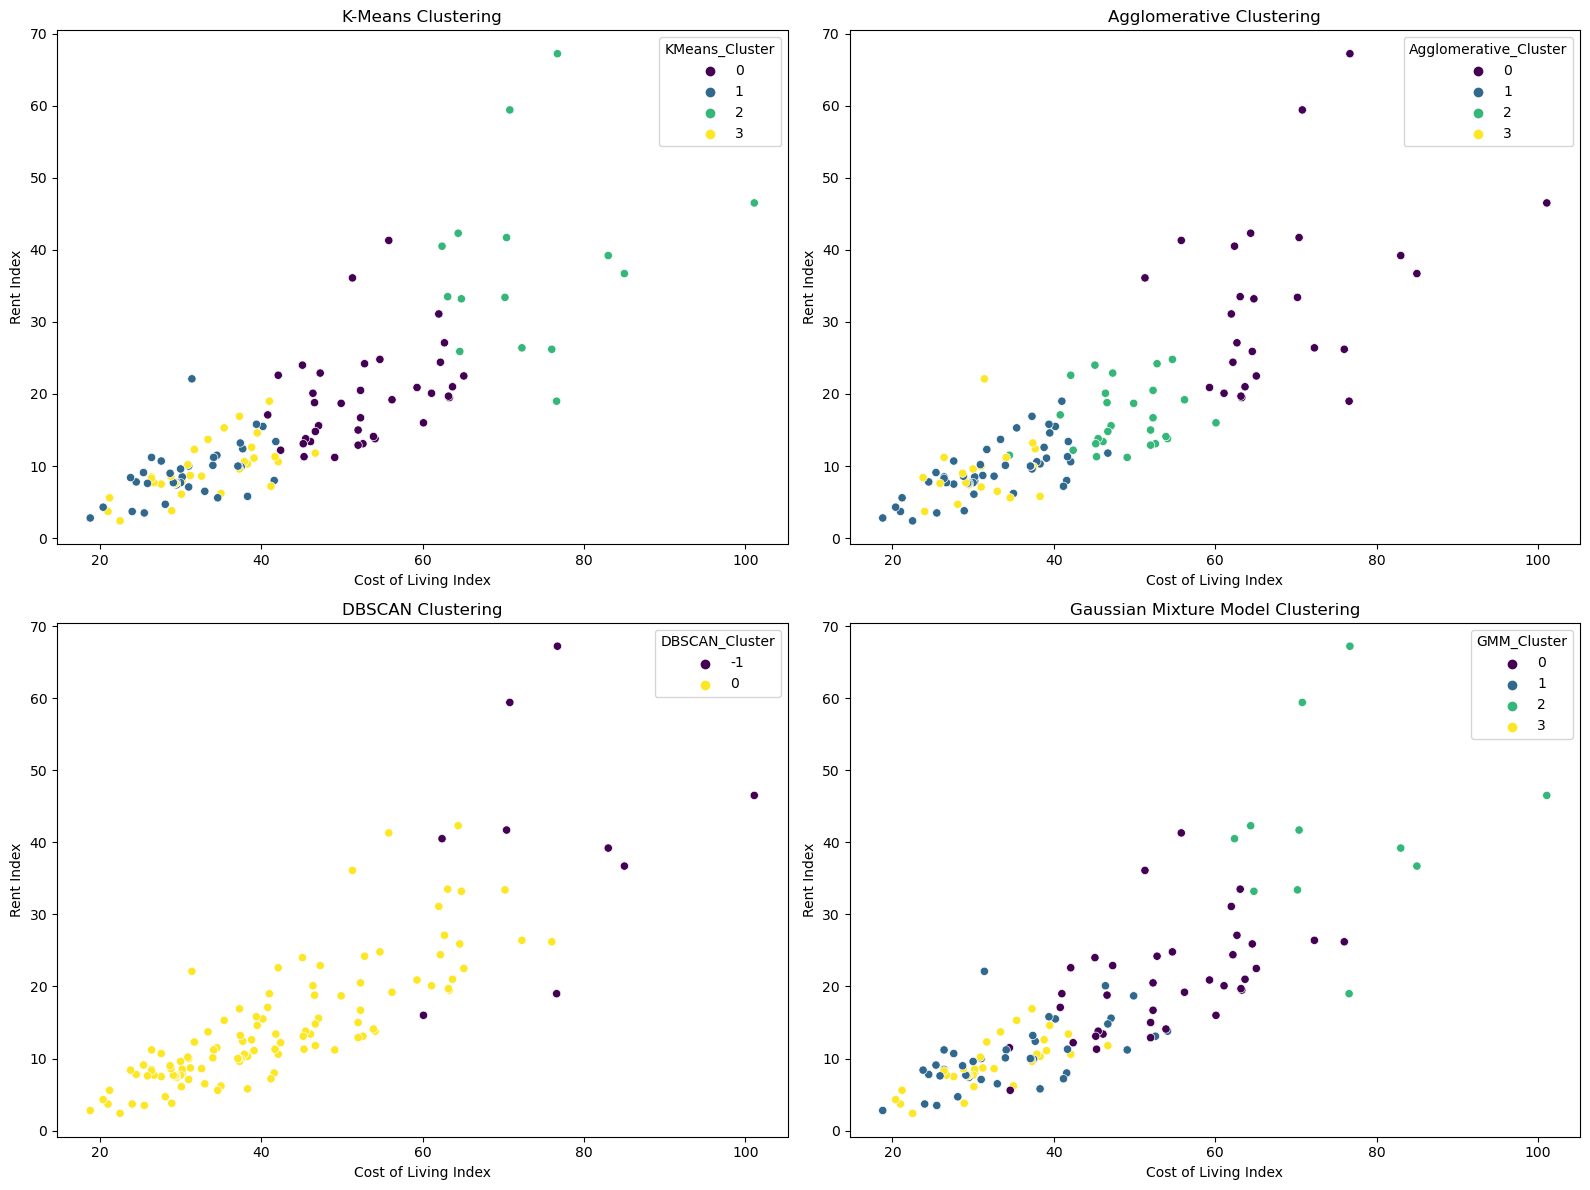

In [30]:
# 1. K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
features['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)

# 2. Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
features['Agglomerative_Cluster'] = agg_clustering.fit_predict(scaled_features)

# 3. DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=2)  # Adjust eps and min_samples as needed
features['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

# 4. Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=4, random_state=42)
features['GMM_Cluster'] = gmm.fit_predict(scaled_features)

# 5. Hierarchical Clustering (Dendrogram)
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=features.index, distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Visualization of clustering results
plt.figure(figsize=(16, 12))

# K-Means
plt.subplot(2, 2, 1)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='KMeans_Cluster', palette='viridis', data=features)
plt.title('K-Means Clustering')

# Agglomerative Clustering
plt.subplot(2, 2, 2)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='Agglomerative_Cluster', palette='viridis', data=features)
plt.title('Agglomerative Clustering')

# DBSCAN
plt.subplot(2, 2, 3)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='DBSCAN_Cluster', palette='viridis', data=features)
plt.title('DBSCAN Clustering')

# Gaussian Mixture Model
plt.subplot(2, 2, 4)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='GMM_Cluster', palette='viridis', data=features)
plt.title('Gaussian Mixture Model Clustering')

plt.tight_layout()
plt.show()

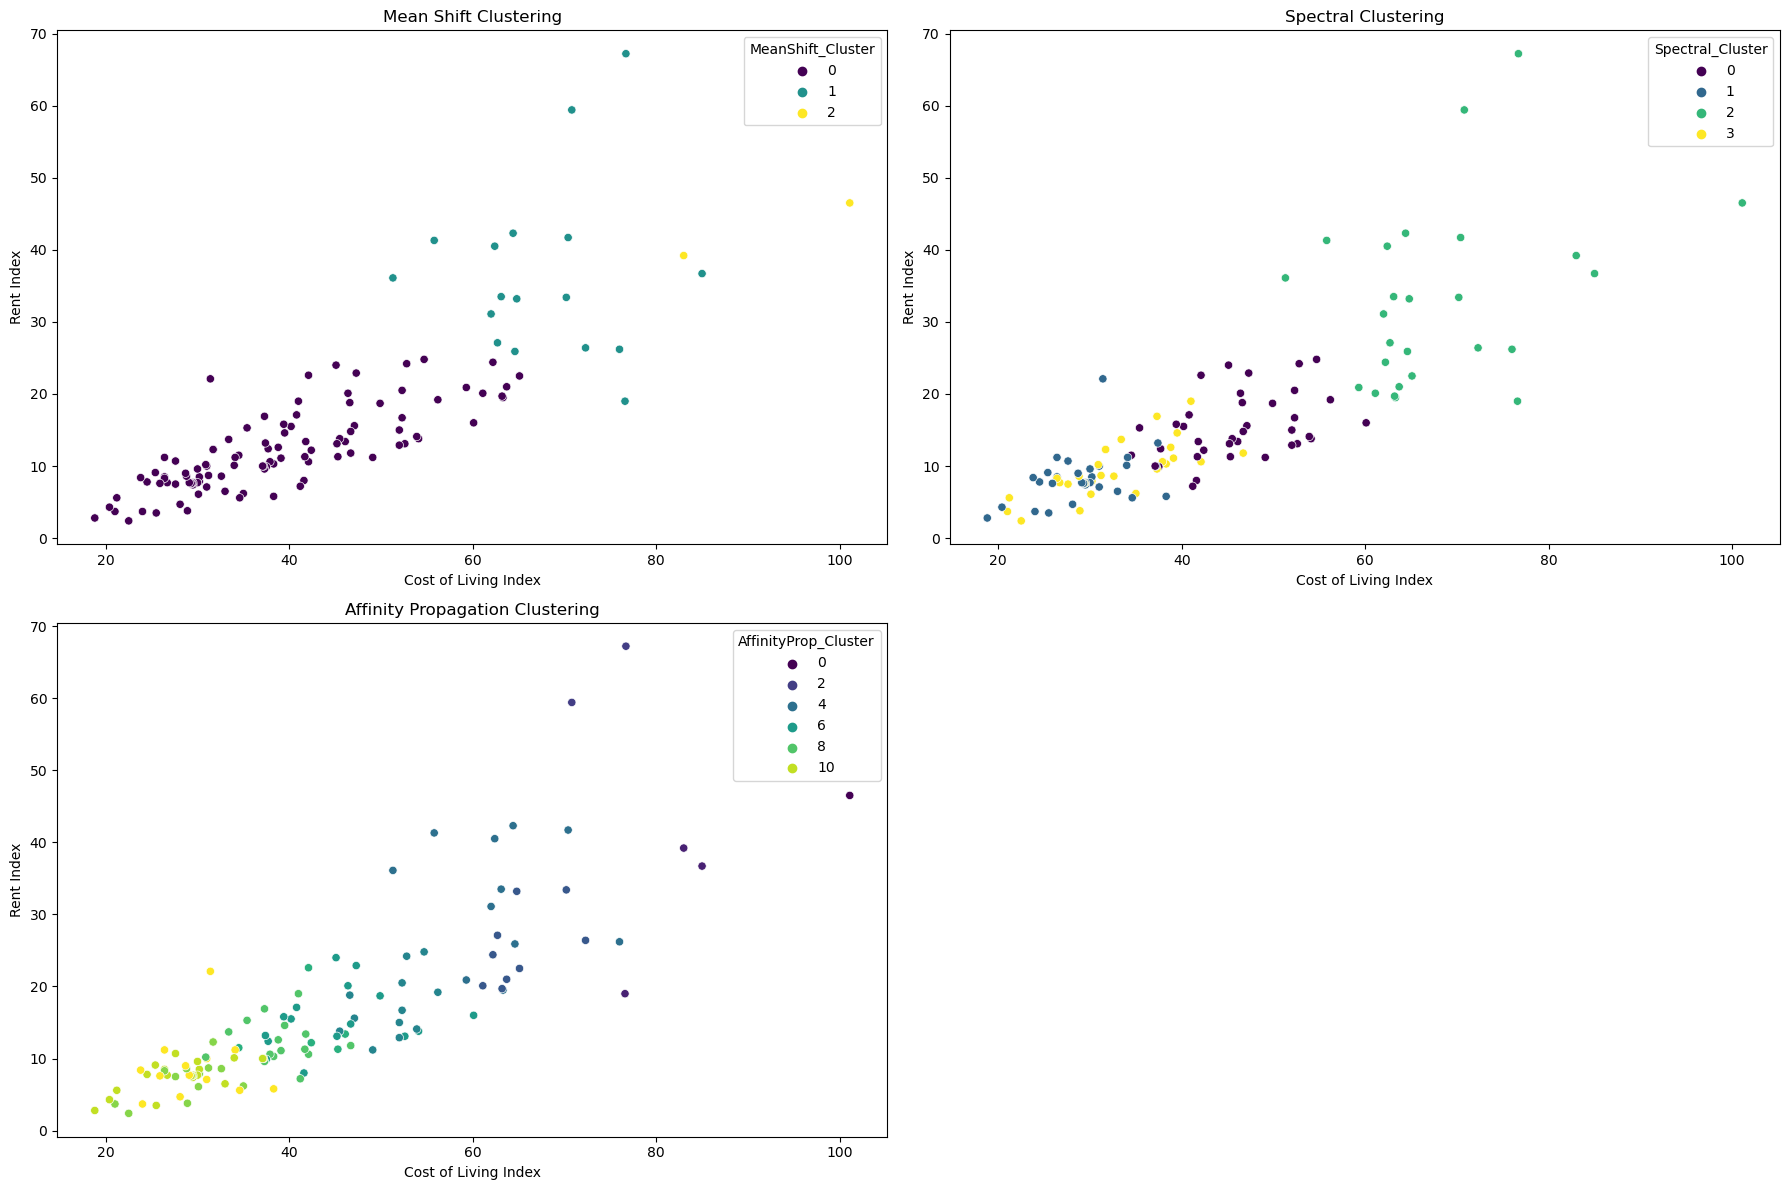

In [35]:
# 1. Mean Shift Clustering
mean_shift = MeanShift()
features['MeanShift_Cluster'] = mean_shift.fit_predict(scaled_features)

# 2. Spectral Clustering
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
features['Spectral_Cluster'] = spectral.fit_predict(scaled_features)

# 3. Affinity Propagation
affinity_prop = AffinityPropagation(random_state=42)
features['AffinityProp_Cluster'] = affinity_prop.fit_predict(scaled_features)


# Visualization of clustering results
plt.figure(figsize=(18, 12))

# Mean Shift
plt.subplot(2, 2, 1)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='MeanShift_Cluster', palette='viridis', data=features)
plt.title('Mean Shift Clustering')

# Spectral Clustering
plt.subplot(2, 2, 2)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='Spectral_Cluster', palette='viridis', data=features)
plt.title('Spectral Clustering')

# Affinity Propagation
plt.subplot(2, 2, 3)
sns.scatterplot(x='Cost of Living Index', y='Rent Index', hue='AffinityProp_Cluster', palette='viridis', data=features)
plt.title('Affinity Propagation Clustering')


plt.tight_layout()
plt.show()